<a href="https://colab.research.google.com/github/nyinyi979/AI-BE/blob/main/ai_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomCrop(32, padding=4),  # Random cropping with padding
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization for test set
])
batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="./cnn-data", train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./cnn-data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


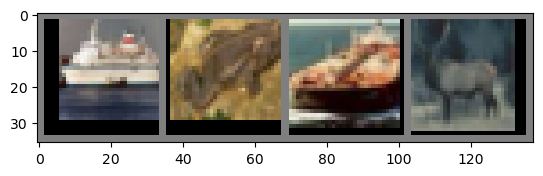

ship    frog    ship    deer   


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# viewing sample images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:7s}' for j in range(batch_size)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

num_classes = 10
feature_size = 1024  # Reduce the feature size for faster training

# Optimized CNN Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        # Batch Normalization after each conv layer
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(192)
        self.bn3 = nn.BatchNorm2d(384)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, feature_size)
        self.fc2 = nn.Linear(feature_size, num_classes)
        
        # Dropout layers
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Convolutional layers with BatchNorm and ReLU activations
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = F.relu(self.bn4(self.conv4(x)))
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer (logits for classification)
        
        return x

# Model initialization
net = Net()

In [11]:
# Accuracy function
def accuracy_fn(y_true, y_pred):
    y_pred = y_pred.argmax(dim=1)  # Get the predicted class (from logits)
    return accuracy_score(y_true.cpu(), y_pred.cpu()) * 100  # accuracy in percentage

In [12]:
from torch.utils.data import DataLoader
# Train step
def train_step(model: torch.nn.Module,
               data_loader: DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to device (GPU or CPU)
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # accumulate the loss

        # 3. Calculate accuracy
        train_acc += accuracy_fn(y, y_pred)

        # 4. Optimizer zero grad
        optimizer.zero_grad()

        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

    # Average loss and accuracy over the dataset
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

# Test step
def test_step(model: torch.nn.Module,
              data_loader: DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():  # No gradients needed during inference
        for X, y in data_loader:
            # Send data to device (GPU or CPU)
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss
            test_loss += loss_fn(test_pred, y).item()

            # 3. Calculate accuracy
            test_acc += accuracy_fn(y, test_pred)

    # Average loss and accuracy over the dataset
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    return test_loss, test_acc



In [13]:
import torch.optim as optim
from sklearn.metrics import accuracy_score


# Example usage (assuming you have data_loader, optimizer, and loss_fn set up)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()


# Train and test loop
# train_loss, train_acc = train_step(model, trainloader, loss_fn, optimizer, accuracy_fn, device)
# test_loss, test_acc = test_step(model, testloader, loss_fn, accuracy_fn, device)


In [14]:
def print_train_time(start, end, device):
    """Prints the total training time."""
    total_time = end - start
    minutes = total_time // 60
    seconds = total_time % 60
    print(f"Training completed on {device} in {minutes:.0f} minutes and {seconds:.2f} seconds.")
    return total_time


**TRAINING AND TESTING THE MODEL**

In [15]:
#from helper_functions import accuracy_fn
import torch
from timeit import default_timer as timer
from tqdm import tqdm

torch.manual_seed(42)

# 1. Create an empty results dictionary
results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

# Measure time
train_time_start = timer()

# 2. Train and test model for a specified number of epochs
epochs = 8
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")

    # Train step
    train_loss, train_acc = train_step(
        data_loader=trainloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    # Test step
    test_loss, test_acc = test_step(
        data_loader=testloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    scheduler.step()
    # 3. Update results dictionary with the losses and accuracies
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

# Measure total training time
train_time_end = timer()
total_train_time = print_train_time(start=train_time_start, end=train_time_end, device=device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.78764 | Train accuracy: 34.38%


 12%|█▎        | 1/8 [02:50<19:56, 170.93s/it]

Test loss: 1.47935 | Test accuracy: 49.16%

Epoch: 1
---------
Train loss: 1.47876 | Train accuracy: 47.04%


 25%|██▌       | 2/8 [06:05<18:29, 184.93s/it]

Test loss: 1.34111 | Test accuracy: 54.11%

Epoch: 2
---------
Train loss: 1.32231 | Train accuracy: 53.35%


 38%|███▊      | 3/8 [09:22<15:52, 190.54s/it]

Test loss: 1.08265 | Test accuracy: 62.37%

Epoch: 3
---------
Train loss: 1.20741 | Train accuracy: 57.79%


 50%|█████     | 4/8 [13:05<13:32, 203.25s/it]

Test loss: 0.99028 | Test accuracy: 65.27%

Epoch: 4
---------
Train loss: 1.12352 | Train accuracy: 60.85%


 62%|██████▎   | 5/8 [16:17<09:57, 199.08s/it]

Test loss: 0.92734 | Test accuracy: 67.76%

Epoch: 5
---------
Train loss: 0.97853 | Train accuracy: 65.82%


 75%|███████▌  | 6/8 [18:59<06:13, 186.57s/it]

Test loss: 0.82679 | Test accuracy: 70.64%

Epoch: 6
---------
Train loss: 0.92365 | Train accuracy: 68.03%


 88%|████████▊ | 7/8 [22:13<03:08, 188.85s/it]

Test loss: 0.77227 | Test accuracy: 73.18%

Epoch: 7
---------
Train loss: 0.89708 | Train accuracy: 68.91%


100%|██████████| 8/8 [26:24<00:00, 198.05s/it]

Test loss: 0.80691 | Test accuracy: 72.38%

Training completed on cpu in 26 minutes and 24.46 seconds.


In [16]:
from typing import Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

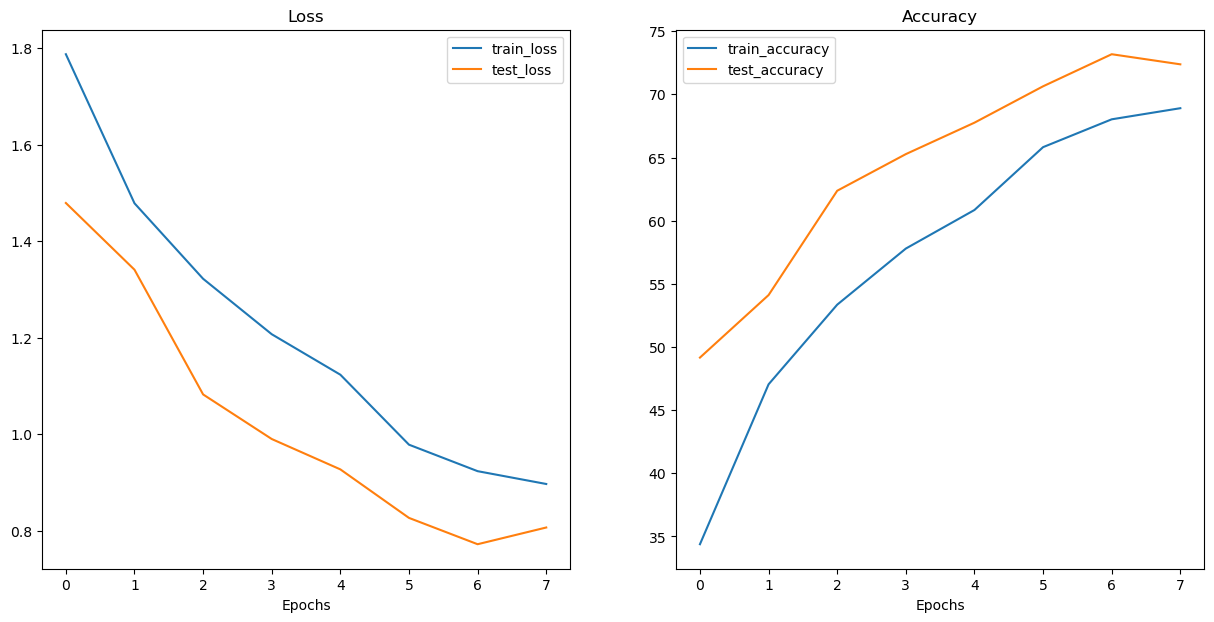

In [17]:
plot_loss_curves(results)

**Making PREDICTIONS WITH OUR MODELS**

In [18]:
import torch
import matplotlib.pyplot as plt

def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    # training mode disabled 
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device)  # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probabilities (logits -> probabilities)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)  # Apply softmax on the logits

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [19]:
import random
# Sample 9 random images and labels from the test dataset
test_samples = []
test_labels = []
for sample, label in random.sample(list(testset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes[test_labels[0]]})")



Test sample image shape: torch.Size([3, 32, 32])
Test sample label: 6 (frog)


In [20]:
# Make predictions on test samples with the trained model
pred_probs = make_predictions(model=model, data=test_samples, device=device)

# View first two prediction probabilities
print(pred_probs[:2])


tensor([[0.0136, 0.0021, 0.0899, 0.3124, 0.1647, 0.2353, 0.0364, 0.1373, 0.0041,
         0.0041],
        [0.0315, 0.1949, 0.0058, 0.0042, 0.0020, 0.0018, 0.0288, 0.0039, 0.1390,
         0.5881]])


In [21]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 9, 9, 4, 9, 7, 1, 1, 0])

In [22]:
# Are our predictions in the same form as our test labels?
print(f"True labels: {test_labels}")
print(f"Predicted labels: {pred_classes.numpy()}")

True labels: [6, 1, 9, 4, 9, 7, 1, 6, 0]
Predicted labels: [3 9 9 4 9 7 1 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.99215686].
Clipping i

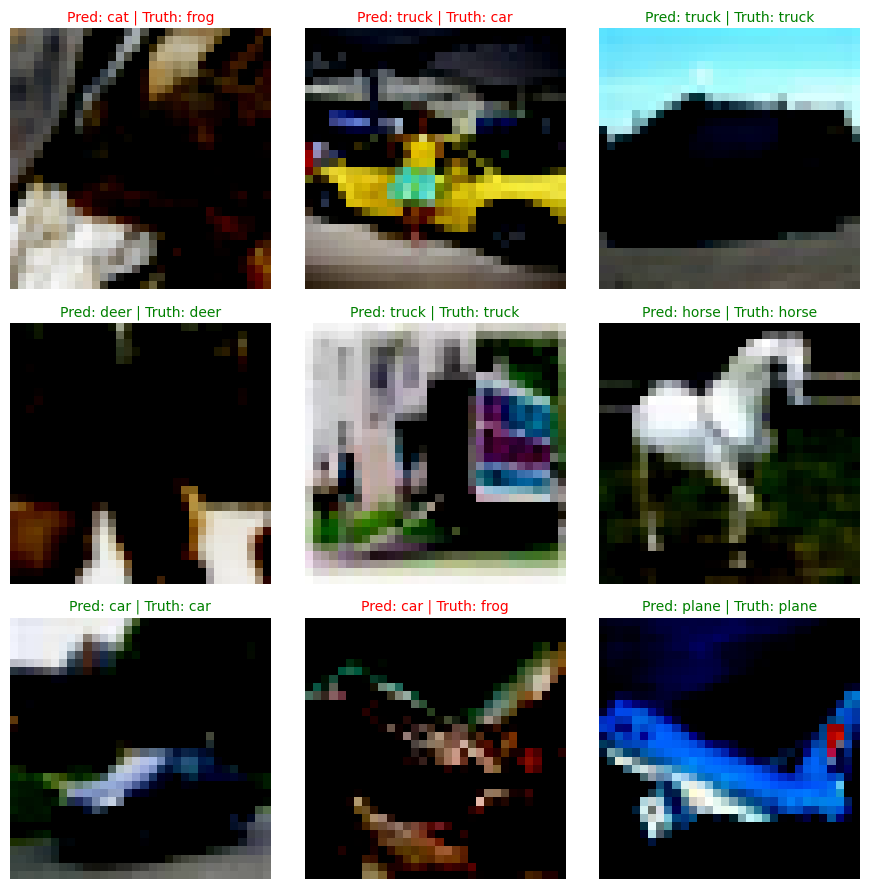

In [23]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0))  # CIFAR-10 images are in (C, H, W) format, so permute to (H, W, C)

    # Find the prediction label (in text form, e.g. "cat")
    pred_label = classes[pred_classes[i]]

    # Get the truth label (in text form, e.g. "dog")
    truth_label = classes[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if wrong
    plt.axis(False)

plt.tight_layout()
plt.show()

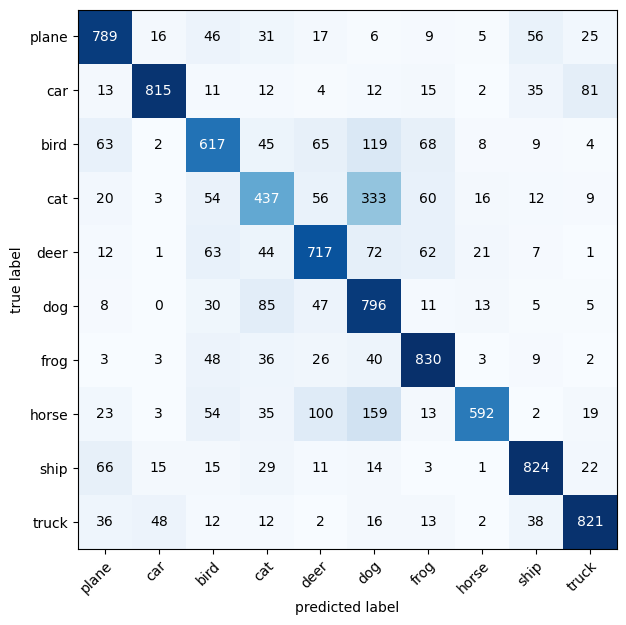

In [26]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torch

# 1. Collect the model predictions and true labels
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in testloader:
        # Send data to the device
        images, labels = images.to(device), labels.to(device)

        # Get predictions from the model
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels to the lists
        y_pred.append(predicted.cpu())
        y_true.append(labels.cpu())

# Convert lists to tensors
y_pred_tensor = torch.cat(y_pred)
y_true_tensor = torch.cat(y_true)

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=y_true_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # Convert the confusion matrix tensor to a NumPy array
    class_names=classes,  # CIFAR-10 class names
    figsize=(10, 7)
)
plt.show()


In [27]:
import torch
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)